In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
import spacy
from modified_anchor import anchor_text
import pickle
import myUtils
from myUtils import *
from transformer.utils import *
from dataset.dataset_loader import *
import datetime

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# can be sentiment/spam/offensive/corona
dataset_name = 'sentiment'
optimization = ''
folder_name = f'results/{dataset_name}-{optimization}' if len(optimization)>0 else f'results/{dataset_name}'
text_parser, label_parser, ds_train, ds_val = get_dataset(dataset_name)

Number of tokens in training samples: 6407
Number of tokens in training labels: 2


In [3]:
model = load_model('gru' , f'transformer/{dataset_name}/gru.pt', text_parser)
myUtils.model = torch.jit.script(model)
myUtils.text_parser = text_parser

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0001, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(6407, 100)
  (GRU_layer): GRU(100, 128, num_layers=2, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


# Anchor Part

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
explainer = anchor_text.AnchorText(nlp, ['positive', 'negative'], use_unk_distribution=False)

# Loading Results

In [6]:
test = np.array(pickle.load(open(f"{folder_name}/test.pickle", "rb" )))
test_labels = np.array(pickle.load(open(f"{folder_name}/test_labels.pickle", "rb" )))
explanations  = pickle.load(open(f"{folder_name}/exps_list.pickle", "rb" ))
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))

In [7]:
len(anchor_examples)

3086

In [8]:
len(explanations)

35001

In [9]:
if not os.path.exists(f"{folder_name}/predictions.pickle"):
    predictions = [predict_sentences([str(anchor_example)])[0] for anchor_example in anchor_examples]
    pickle.dump( predictions, open(f"{folder_name}/predictions.pickle", "wb" ))
    
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))

In [10]:
from functools import reduce
# get all anchor above 0.95, multiple in a sentence but word counts only once in a sentence
def get_best(explanations):
    best_exps = dict()
    for exp in explanations:
        if exp.precision < 0.95:
            continue
        if exp.index not in best_exps.keys():
            best_exps[exp.index]=[exp]
        # if word already appeard in sentence
        elif any([cur_exp.names[0]==exp.names[0] for cur_exp in best_exps[exp.index]]):
            continue
        else:
            best_exps[exp.index].append(exp)
    print(len(best_exps))
    return reduce(lambda x,y: x+y, best_exps.values())

In [11]:
from collections import Counter

def get_anchor_occurences(explanations):
    c = Counter()
    for exp in explanations:
        c.update([exp.names[0]])
 
    return c

def get_normal_occurences(sentences, anchor_occurences):
    c = Counter()
    for sentence in sentences:
        c.update([x.text for x in nlp.tokenizer(sentence)])
   
    #removing occurences of the words as anchor
    for word in anchor_occurences.keys():
        c[word]-=anchor_occurences[word]
        
    return c

def smooth_before(normal_occurences, anchor_occurences_list):
    for w in normal_occurences:
        normal_occurences[w]+=1
        for anchor_occurences in anchor_occurences_list:
            anchor_occurences[w]+=1

def smooth_after(teta1, type_occurences):
    # removing words we added 1 at the start smooth
    words = list(teta1.keys())
    for word in words:
        if type_occurences[word]<=1:
            del teta1[word]
    
    min_val = min(teta1.values())
    if min_val<0:
        for w in teta1:
            teta1[w]-= min_val
        sum_val = sum(teta1.values())
        for w in teta1:
            teta1[w]= teta1[w]/sum_val

In [12]:
def calculate_teta0(normal_occurences):
    teta0 = dict()
    sum_occurences = sum(normal_occurences.values())
    for word, count in normal_occurences.items():
        teta0[word] = count/sum_occurences
    
    return teta0

def calculate_teta1(anchor_occurences, teta0, alpha):
    teta1 = dict()
    sum_occurences = sum(anchor_occurences.values())
    for word, count in anchor_occurences.items():
        teta1[word] = count/sum_occurences -(1-alpha)*teta0[word]
        teta1[word] = teta1[word]/alpha
    
    return teta1

In [45]:
def calculate_scores():
    alphas = [0.95, 0.8, 0.65, 0.5]
    dfs = []
    columns = ['name', 'anchor score', 'type occurences', 'total occurences','+%', '-%', 'both', 'normal']
    
    exps = get_best(explanations)
    pos_exps = [exp for exp in exps if labels[exp.index]==0]
    neg_exps = [exp for exp in exps if labels[exp.index]==1]
    
    anchor_occurences = get_anchor_occurences(exps)
    pos_occurences = get_anchor_occurences(pos_exps)
    neg_occurences = get_anchor_occurences(neg_exps)
    
    normal_occurences = get_normal_occurences(anchor_examples, anchor_occurences)
    smooth_before(normal_occurences, [pos_occurences, neg_occurences])

    teta0 = calculate_teta0(normal_occurences)
    
    
    for alpha in alphas:
        df_pos, df_neg = [], []
        
        teta_pos = calculate_teta1(pos_occurences, teta0, alpha)
        smooth_after(teta_pos, pos_occurences)
        
        teta_neg = calculate_teta1(neg_occurences, teta0, alpha)
        smooth_after(teta_neg, neg_occurences)
        
        # substracting 1 because of the smoothing
        for anchor, score in teta_pos.items():
            pos_percent = round((pos_occurences[anchor]-1)/anchor_occurences[anchor], 2)
            neg_percent = 1-pos_percent
            both = (pos_occurences[anchor]-1)>0 and (neg_occurences[anchor]-1)>0
            df_pos.append([anchor, score , pos_occurences[anchor]-1, anchor_occurences[anchor], pos_percent, neg_percent, both,  normal_occurences[anchor]-1]) 
            
        
        for anchor, score in teta_neg.items():
            pos_percent = round((pos_occurences[anchor]-1)/anchor_occurences[anchor], 2)
            neg_percent = 1-pos_percent
            both = (pos_occurences[anchor]-1)>0 and (neg_occurences[anchor]-1)>0
            df_neg.append([anchor, score , neg_occurences[anchor]-1, anchor_occurences[anchor], pos_percent, neg_percent, both,  normal_occurences[anchor]-1]) 
            
        df_pos.sort(key=lambda exp: -exp[1])
        df_neg.sort(key=lambda exp: -exp[1])
        df_pos = pd.DataFrame(data = df_pos, columns = columns ).set_index('name')
        df_neg = pd.DataFrame(data = df_neg, columns = columns ).set_index('name')
        
        dfs.extend([df_pos, df_neg])
        
    writer = pd.ExcelWriter(f'{folder_name}/scores.xlsx',engine='xlsxwriter') 
    
    workbook=writer.book
    worksheet=workbook.add_worksheet('Sheet1')
    writer.sheets['Sheet1'] = worksheet
    
    cur_col = 0
    is_positive = True
    alphas = np.repeat(alphas, 2)
    
    for df, alpha in zip(dfs, alphas):
        cur_type = 'positive' if is_positive else 'negative'
        is_positive = not is_positive
        worksheet.write(0, cur_col, f'{alpha}-{cur_type}')
        df.to_excel(writer, sheet_name=f'Sheet1', startrow=1, startcol=cur_col)
        cur_col+= len(columns) + 1

    writer.save()

In [46]:
calculate_scores()

1695


In [39]:
def compare_loss(path1, path2):
    results = []
    
    def intersect_df(d1, d2, top):
        s1 = set(d1.head(top).tolist())
        s2 = set(d2.head(top).tolist())
        percentage = len(s1.intersection(s2))/top
        
        return percentage
              
    alphas = [0.95, 0.8, 0.65, 0.5]
    top = 25
    df1 = pd.read_excel(path1).drop(0)
    df2 = pd.read_excel(path2).drop(0)
    
    for alpha in alphas:
      
        pos_percentage = intersect_df(df1[f'{alpha}-positive'], df2[f'{alpha}-positive'], top)
        
        neg_percentage = intersect_df(df1[f'{alpha}-negative'], df2[f'{alpha}-negative'], top)
        
        results.append([alpha, pos_percentage, neg_percentage])
    
    df = pd.DataFrame(data = results, columns = ['alpha', 'pos', 'neg']).set_index('alpha')
    return df

In [40]:
compare_loss(f'{folder_name}/scores.xlsx', f'results/{dataset_name}/scores.xlsx')

,pos,neg
alpha,,
0.95,1.0,1.0
0.80,1.0,1.0
0.65,1.0,1.0
0.50,1.0,1.0


In [41]:
import csv
import matplotlib.pyplot as plt
def present_monitor():
    top = 25
    df = pd.read_excel(f'{folder_name}/scores.xlsx').drop(0).head(top)
    
    with open(f'{folder_name}/pos_monitor.csv', "r") as f:
        reader = csv.reader(f)
        pos_lines = [line for line in reader]

    with open(f'{folder_name}/neg_monitor.csv', "r") as f:
        reader = csv.reader(f)
        neg_lines = [line for line in reader]
        
    with open(f'{folder_name}/time_monitor.csv', "r") as f:
        reader = csv.reader(f)
        time_lines = [float(line[0]) for line in reader]

    alphas = [0.95, 0.8, 0.65, 0.5]
    results = dict.fromkeys(alphas, {'pos': [], 'neg': []})
    
    for i, alpha in enumerate(alphas): 
        top_pos = set(df[f'{alpha}-positive'].to_list())
        top_neg = set(df[f'{alpha}-negative'].to_list())
        
        results[alpha]['pos'] = [len(top_pos.intersection(set(line)))/top for line in pos_lines]
        results[alpha]['neg'] = [len(top_neg.intersection(set(line)))/top for line in neg_lines]
        
        plt.plot(time_lines, results[alpha]['pos'], label = 'positive')
        plt.plot(time_lines, results[alpha]['neg'], label = 'negative')
        plt.xlabel('time (minutes)')
        plt.ylabel('percent')

        plt.title(alpha)
        plt.legend()
        plt.show()
    

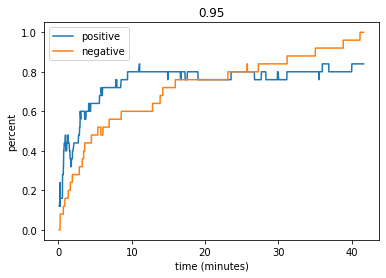

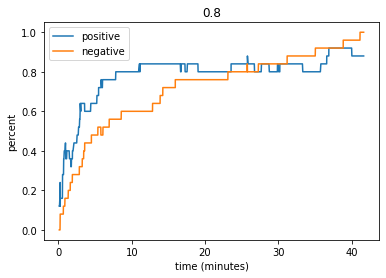

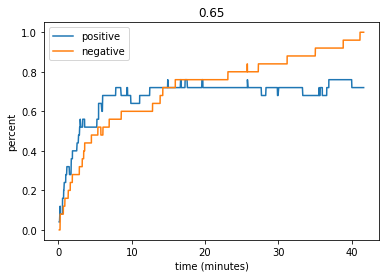

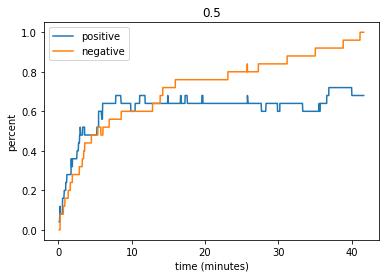

In [42]:
dataset_name = 'sentiment'
optimization = ''
folder_name = f'results/{dataset_name}-{optimization}' if len(optimization)>0 else f'results/{dataset_name}'
present_monitor()

In [43]:
import csv
import matplotlib.pyplot as plt
def present_monitor2():
    top = 25
    
    with open(f'{folder_name}/pos_monitor.csv', "r") as f:
        reader = csv.reader(f)
        pos_lines = [line for line in reader]

    with open(f'{folder_name}/neg_monitor.csv', "r") as f:
        reader = csv.reader(f)
        neg_lines = [line for line in reader]
        
    with open(f'{folder_name}/time_monitor.csv', "r") as f:
        reader = csv.reader(f)
        time_lines = [float(line[0]) for line in reader]

    alphas = [0.95, 0.8, 0.65, 0.5]
    results = dict()
    
    top_pos = set(pos_lines[-1])
    top_neg = set(neg_lines[-1])

    results['pos'] = [len(top_pos.intersection(set(line)))/top for line in pos_lines]
    results['neg'] = [len(top_neg.intersection(set(line)))/top for line in neg_lines]

    plt.plot(time_lines, results['pos'], label = 'positive')
    plt.plot(time_lines, results['neg'], label = 'negative')
    plt.xlabel('time (minutes)')
    plt.ylabel('percent')

    plt.legend()
    plt.show()
    

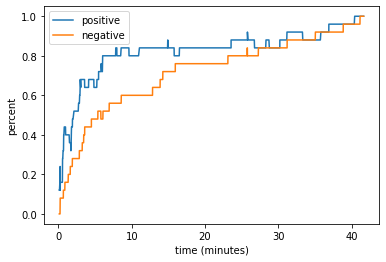

In [44]:
dataset_name = 'sentiment'
optimization = ''
folder_name = f'results/{dataset_name}-{optimization}' if len(optimization)>0 else f'results/{dataset_name}'
present_monitor2()